# <span style = "color:green">Финальный проект на курсе "Анализ данных" на KARPOV.COURCES <span>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import pandahouse as ph

import requests
from urllib.parse import urlencode

from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 5]

# <span style="color:blue">Задание 1. A/B - тестирование<span>

## Первичный анализ данных

In [2]:
# использование api 
def url(public_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_key))
    response_active = requests.get(final_url)
    download_url = response_active.json()['href']
    return download_url

In [3]:
url_actives = url('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ' )
active = pd.read_csv(url_actives)
url_checks = url('https://disk.yandex.ru/d/pH1q-VqcxXjsVA')
checks = pd.read_csv(url_checks, sep=';')
url_groups = url('https://disk.yandex.ru/d/UhyYx41rTt3clQ' )
groups = pd.read_csv(url_groups, sep=';')
url_group_add = url('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
group_add = pd.read_csv(url_group_add)

Изменим наименования столбцов

In [4]:
groups.rename(columns = {'id':'student_id',
                         'grp':'group'}, inplace = True)

In [5]:
print('Общее количество униальных пользователей:', groups.student_id.count())
print('A:',
      groups.query('group == "A"').student_id.count(),
      "{:.2%}".format(groups.query('group == "A"').student_id.count()/groups.student_id.count()))
print('B:',
      groups.query('group == "B"').student_id.count(),
      "{:.2%}".format(groups.query('group == "B"').student_id.count()/groups.student_id.count()))

Общее количество униальных пользователей: 74484
A: 14671 19.70%
B: 59813 80.30%


Все ли активные пользователи приняли участие в АБ-тесте?

In [6]:
act_group = active.merge(groups, how = 'left', on = 'student_id')
act_group[act_group.group.isnull()]

,student_id,group
1,5723133,NaN
111,5951797,NaN
632,5730382,NaN
2662,5739944,NaN
3830,5945085,NaN
4900,5700613,NaN
5254,5729371,NaN
5746,5777081,NaN
7413,5740903,NaN
7505,5760471,NaN


Имеются пользователи, не получившие метки группы, и все student_id примерно одного значения

In [7]:
print('Максимальный student_id в groups:',groups.student_id.max())
print('Максимальный student_id в checks:',checks.student_id.max())

Максимальный student_id в groups: 5694419
Максимальный student_id в checks: 5740903


Видим, что пользователи, не получившие свои метки, имеют student_id больше, чем в таблицах groups и checks. <br>
Возможно имеет место ошибка при выгрузке данных

In [8]:
checks_group = checks.merge(groups, how = 'left', on = 'student_id')
checks_group[checks_group.group.isnull()]

,student_id,rev,group
540,5740903,1900.0,NaN


In [9]:
checks_active = checks.merge(active, how = 'outer', on = 'student_id',indicator = True)
print('Пользователи checks, отсутствующие в active',checks_active.query('_merge == "left_only"').student_id.count())
print('Сумма пользователей checks, отсутствующих в active',checks_active.query('_merge == "left_only"').rev.sum())

Пользователи checks, отсутствующие в active 149
Сумма пользователей checks, отсутствующих в active 105532.0001


Не все пользователи из checks присутствуют в active. При этом и доля самих этих пользователей в checks и их сумма значительны

In [10]:
print('Доля пользователей checks, отсутствующих в active:',
      "{:.2%}".format(checks_active.query('_merge == "left_only"').student_id.count()/checks.student_id.count()))
print('Доля суммы пользователей checks, отсутствующих в active:',
      "{:.2%}".format(checks_active.query('_merge == "left_only"').rev.sum()/checks.rev.sum()))

Доля пользователей checks, отсутствующих в active: 27.54%
Доля суммы пользователей checks, отсутствующих в active: 18.41%


Вероятнее всего эти пользователи, не смотря на наличие чеков, действительно не проявляли активности в период теста и соответственно не принимали участие в самом тесте

Также я заметил "странный" чек на сумму 1900.0001, который выбивается из общего ряда. Думаю его стоит заменить на 1900

In [11]:
checks.rev.replace(1900.0001,1900.0,inplace = True)

Построим распределение сумм

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Пользователи, чел.')

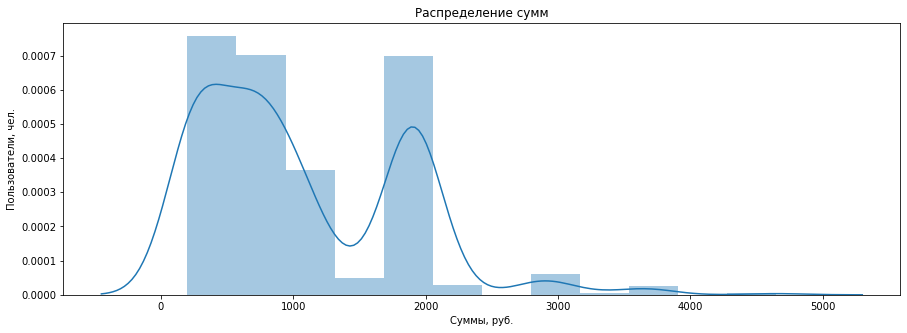

In [12]:
sns.distplot(checks.rev)
plt.title('Распределение сумм')
plt.xlabel('Суммы, руб.')
plt.ylabel('Пользователи, чел.')

Соберем итоговый датафрей. Возьмем активных пользователей с метками группы АБ-теста

In [13]:
final_df = active.merge(checks, how = 'left', on = 'student_id')
final_df = final_df.merge(groups, how = 'inner', on = 'student_id')
final_df['paid'] = final_df.rev.apply(lambda x: 1 if x > 0 else 0)

In [14]:
final_df.head()

,student_id,rev,group,paid
0,581585,NaN,A,0
1,3276743,NaN,B,0
2,4238589,NaN,A,0
3,4475369,NaN,B,0
4,5481015,NaN,B,0


## Анализ A/B - теста

1) Нулевая гипотеза: при внедрении новой механики оплаты на сайте конверсия не изменится <br>
2) Уровено значимости: 0.05 <br>
3) Метрика: конверсия в покупку. <br>
Проверим эту метрику, так как основное воздействие новой механики оплаты должно быть именно на нее. При этом дополнительно проверим изменение среднего чека и среднего чека платящего пользователя <br>
CR<br>
ARPU <br>
ARPPU<br>

In [15]:
final_df.groupby('group',as_index = False)\
    .agg({'student_id':'count'})
print('Общее количество униальных пользователей:', final_df.student_id.count())
print('A:',
      final_df.query('group == "A"').student_id.count(),
      "{:.2%}".format(final_df.query('group == "A"').student_id.count()/final_df.student_id.count()))
print('B:',
      final_df.query('group == "B"').student_id.count(),
      "{:.2%}".format(final_df.query('group == "B"').student_id.count()/final_df.student_id.count()))

Общее количество униальных пользователей: 8328
A: 1535 18.43%
B: 6793 81.57%


Как можем заметить распределение пользователей по группам неравномерное. Это видимо связано с тем, что пользователи были распределены заранее и так вышло, что большая часть активных пришлась на тестовую группу. <br>
Желательно чтобы распределение было 50/50. Я думаю лучше бы было, если пользователя определяли в группу на этапе входа на сайт, что уже говорит о его активности

Посчитаем метрики для групп

In [16]:
metrics = final_df.groupby('group',as_index = False)\
                    .aggregate({'student_id':'count',
                                'rev':'sum'})\
                    .rename(columns = {'student_id':'users'})

metrics['paying_users'] = final_df.query('paid == 1')\
                            .groupby('group',as_index = False)\
                            .agg({'student_id':'count'}).student_id
metrics['not_paying_users'] = final_df.query('paid == 0')\
                            .groupby('group',as_index = False)\
                            .agg({'student_id':'count'}).student_id

metrics['CR'] = (metrics.paying_users/metrics.users).round(3).apply("{:.2%}".format)
metrics['ARPU'] = (metrics.rev/metrics.users).round(2)
metrics['ARPPU'] = (metrics.rev/metrics.paying_users).round(2)
metrics = metrics[['group', 'users', 'paying_users', 'not_paying_users',  'rev','CR', 'ARPU', 'ARPPU']]
metrics.rename(columns = {
    'group':'Группа',
    'users':'Количество пользователей',
    'paying_users':'Количество оплативших пользователей',
    'not_paying_users':'Количество неоплативших пользователей',
    'rev':'Выручка'
})

,Группа,Количество пользователей,Количество оплативших пользователей,Количество неоплативших пользователей,Выручка,CR,ARPU,ARPPU
0,A,1535,78,1457,72820.0,5.10%,47.44,933.59
1,B,6793,313,6480,393074.0,4.60%,57.86,1255.83


Значения CR, ARPU, ARPPU выше в тестовой группе <br> 
Теперь проверим значения статистически <br> 
Для конверсии будет использовать критерий Хи - квадрат, так как показатель качественный

In [17]:
A = metrics.set_index('group')[['not_paying_users', 'paying_users']].loc['A'].to_list()
B = metrics.set_index('group')[['not_paying_users', 'paying_users']].loc['B'].to_list()
chi2, p, dof, ex = chi2_contingency([A, B], correction=False)

print("Хи-квадрат p-value: ","{:.2%}".format(p))

Хи-квадрат p-value:  42.81%


В итоге вероятность получить значение конверсии как в тестовой группе 42,81%, что значимо и не позволяет отклонить нулевую гипотезу.<br>
Отсюда следует, что изменение CR от смены метода оплаты статистически незначимо

Text(0, 0.5, 'Пользователи, чел.')

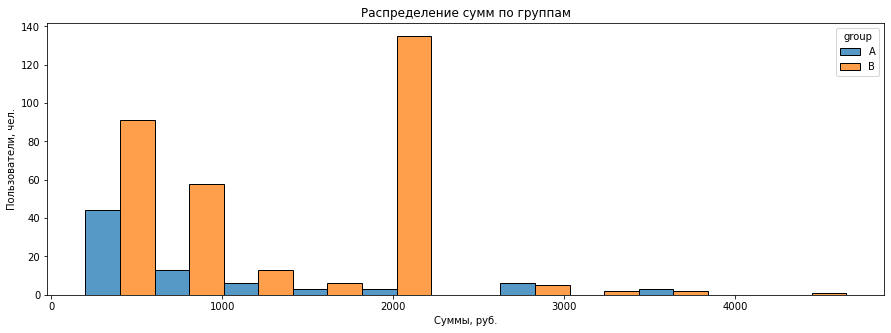

In [18]:
sns.histplot(data = final_df, x="rev", hue='group', multiple='dodge')
plt.title('Распределение сумм по группам')
plt.xlabel('Суммы, руб.')
plt.ylabel('Пользователи, чел.')

По распределению выше можно заметить, что самый популярный чек был в тестовой группе. <br>
Есть предположение, что помимо измнения метода оплаты была еще введена другая акция или иное изменение. Из-за чего можно сделать вывод, что эксперимент не является чистым и было также внесено изменение, о котором не было сказано в начале. <br>
В ином случае данный чек должен был бы быть популярен у обоих групп <br>
<br>
Проверим с помощью t-теста распределение чеков по всем пользователям и пользователям с отплатой

In [19]:
# Средний чек пользователей
p = ttest_ind(final_df.fillna(0).query('group == "A"').rev,
                final_df.fillna(0).query('group == "B"').rev)[1]
print('p-value:',p)

p-value: 0.23288011573839099


In [20]:
# Средний чек на пользователей с оплатой
p = ttest_ind(final_df.fillna(0).query('group == "A" & paid == 1').rev,
                final_df.fillna(0).query('group == "B" & paid == 1').rev)[1]
print('p-value:',p)

p-value: 0.001999178560469943


По итогам тестов показатель ARPU (средний чек пользователя) изменился статистически незначимо, так как p-value > 0.05 и мы не можем отклонить нулевую гипотезу. А средний чек платящего пользователя ARPPU изменился статистически значимо (p-value = 0.002) и мы не можем принять нулевую гипотезу о том, что новый мезанизм не влияет на величину показателя.

## Вывод

В результате проведения A/B-теста было выявлено, что новая механика оплаты на сайте не влияет на конверсию в покупку. Для оценки был выбран критерий Хи-квадрат. Посчитанное значение p-value составило ~43%/. <br>
Также с помощью t-теста были проверены проказатели среднего чека пользователя и среднего чека платящего пользователя. По итогам тестов показатель ARPU имел значения 47,4 в контрольной и 57,9 в тестовой, но это изменение было незначимо, так как p-value = 0,2. В то время как у показателя ARPPU в контрольной группе было значение 933.6, а в тестовой 1255.8, p-value = 0.002, что говорит о том, что изменение механики статистически значимо повлияло на средний чек платящего пользователя. <br>
<br>
Также хочу заметить следующее: <br>
1) соотношение тестовой и контрольной группы по количеству пользователей было неравномерным, желательно иметь соотношение 50/50. Стоит подумать над другом методом отбора контроьной и тестовой группы <br>
2) Наблюдалось большое количество пользователей в тестовой группе с чеком 1900. Возможно имела места другая акция или иное изменение, которое повлияло на эксперимент, из-за чего результат нельзя считать полностью достоверным

# <span style="color:blue">Задание 2. SQL<span>

In [21]:
#объявляем параметры подключения
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [22]:
query = """
WITH (
    SELECT
    MAX(toDateTime(timest))
    FROM default.peas
) as max_date
SELECT
count(st_id) as diligent_students
FROM (
    SELECT 
    st_id,
    Count(subject) as solved_tasks
    FROM default.peas
    WHERE
    toMonth(toDateTime(timest)) = toMonth(max_date)
    AND toYear(toDateTime(timest)) = toYear(max_date)
    AND correct = 1
    GROUP BY
    st_id
    HAVING
    solved_tasks >= 20
)
"""
df = ph.read_clickhouse(query, connection = connection_default)
df.head()

,diligent_students
0,136


In [23]:
print('Количество усердных студентов, решивших 20 и более задач:', df.loc[0].to_list()[0])

Количество усердных студентов, решивших 20 и более задач: 136


In [24]:
# Задача SQL 2
query2 = """
SELECT
    test_grp,
    SUM(amount)/COUNT(st_id) as ARPU,
    SUM(IF(active_mark = 1,amount,0))/COUNT(IF(active_mark = 1,st_id,NULL)) as ARPAU,
    COUNT(IF(sales_num > 0, st_id,NULL))/COUNT(st_id) as CR,
    COUNT(IF(sales_num > 0 AND active_mark = 1, st_id, NULL))/COUNT(st_id) as active_CR,
    COUNT(IF(sales_num > 0 AND math_active_mark = 1, st_id, NULL))/COUNT(st_id) as math_active_CR
FROM (
    SELECT
        c.st_id as st_id,
        c.test_grp as test_grp,
        l.sales_num as sales_num,
        l.amount as amount,
        IF(r.solved_tasks > 10, 1, 0) as active_mark,
        IF(r.math_solved_tasks >= 2, 1, 0) as math_active_mark
    FROM (
            SELECT
            st_id,
            COUNT(sale_time) as sales_num,
            SUM(money) as amount
            FROM default.final_project_check
            GROUP BY
            st_id
            ) as l
        RIGHT JOIN
        (
            SELECT
            *
            FROM default.studs
        ) as c
        ON l.st_id = c.st_id
        LEFT JOIN
        (
            SELECT
            st_id,
            COUNT(timest) as solved_tasks,
            COUNT(IF(subject = 'Math',timest,NULL)) as math_solved_tasks
            FROM default.peas
            WHERE
            correct = 1
            GROUP BY
            st_id
            ) as r
        ON c.st_id = r.st_id
    )
GROUP BY
test_grp
"""
df2 = ph.read_clickhouse(query2, connection = connection_default)
df2.head()

,test_grp,ARPU,ARPAU,CR,active_CR,math_active_CR
0,control,4540.983607,10393.700787,0.049180,0.045902,0.016393
1,pilot,11508.474576,29739.583333,0.108475,0.084746,0.020339


In [25]:
for i in ['ARPU','ARPAU']:
    for grp in ['control','pilot']:
        print(i +' ' + grp + ': '+ str(round(df2[df2.test_grp == grp][i].to_list()[0])))
    print()
    
for i in ['CR','active_CR','math_active_CR']:
    for grp in ['control','pilot']:
        number = df2[df2.test_grp == grp][i].to_list()[0]
        number = "{:.2%}".format(number)
        print(i +' ' + grp + ': ' + number)
    print()

ARPU control: 4541
ARPU pilot: 11508

ARPAU control: 10394
ARPAU pilot: 29740

CR control: 4.92%
CR pilot: 10.85%

active_CR control: 4.59%
active_CR pilot: 8.47%

math_active_CR control: 1.64%
math_active_CR pilot: 2.03%



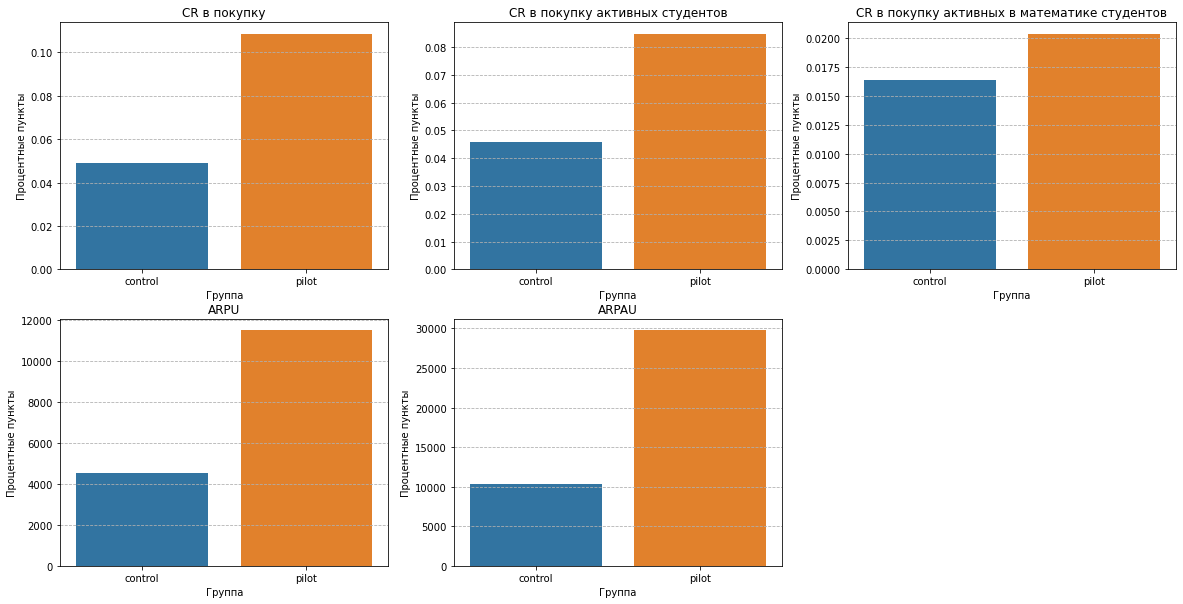

In [26]:
plt.rcParams["figure.figsize"] = [20, 10]

plt.subplot(2,3,1)
sns.barplot(data = df2, x = 'test_grp', y ='CR')
plt.title('CR в покупку')
plt.xlabel("Группа")
plt.ylabel("Процентные пункты")
plt.grid(linestyle='--',axis = 'y') 

plt.subplot(2,3,2)
sns.barplot(data = df2, x = 'test_grp', y ='active_CR')
plt.title('CR в покупку активных студентов')
plt.xlabel("Группа")
plt.ylabel("Процентные пункты")
plt.grid(linestyle='--',axis = 'y') 

plt.subplot(2,3,3)
sns.barplot(data = df2, x = 'test_grp', y ='math_active_CR')
plt.title('CR в покупку активных в математике студентов')
plt.xlabel("Группа")
plt.ylabel("Процентные пункты")
plt.grid(linestyle='--',axis = 'y') 

plt.subplot(2,3,4)
sns.barplot(data = df2, x = 'test_grp', y ='ARPU')
plt.title('ARPU')
plt.xlabel("Группа")
plt.ylabel("Процентные пункты")
plt.grid(linestyle='--',axis = 'y') 

plt.subplot(2,3,5)
sns.barplot(data = df2, x = 'test_grp', y ='ARPAU')
plt.title('ARPAU')
plt.xlabel("Группа")
plt.ylabel("Процентные пункты")
plt.grid(linestyle='--',axis = 'y') 



# <span style="color:blue">Задание 3. Python<span>

## Функция автоматической подгрузки и пересчета данных

In [27]:
def ab_test(groups, group_add, active, checks):
    
    groups = pd.concat([groups, group_add])
    groups.rename(columns = {'id':'student_id','grp':'group'}, inplace = True)
    
    final_df = active.merge(checks, how = 'left', on = 'student_id')
    final_df = final_df.merge(groups, how = 'inner', on = 'student_id')
    final_df['paid'] = final_df.rev.apply(lambda x: 1 if x > 0 else 0)
    final_df.rev.fillna(0,inplace = True)
    
    metrics = final_df.groupby('group',as_index = False)\
                    .aggregate({'student_id':'count',
                                'rev':'sum'})\
                    .rename(columns = {'student_id':'users'})
    metrics['paying_users'] = final_df.query('paid == 1')\
                                .groupby('group',as_index = False)\
                                .agg({'student_id':'count'}).student_id
    metrics['not_paying_users'] = final_df.query('paid == 0')\
                                .groupby('group',as_index = False)\
                                .agg({'student_id':'count'}).student_id
    metrics['CR'] = (metrics.paying_users/metrics.users)
    metrics['ARPU'] = (metrics.rev/metrics.users).round(2)
    metrics['ARPPU'] = (metrics.rev/metrics.paying_users).round(2)
    metrics = metrics[['group', 'users', 'paying_users', 'not_paying_users',  'rev','CR', 'ARPU', 'ARPPU']]
    metrics['rev'] = metrics['rev'].round(0)
    
    display(
        metrics.rename(columns = {
        'group':'Группа',
        'users':'Количество пользователей',
        'paying_users':'Количество оплативших пользователей',
        'not_paying_users':'Количество неоплативших пользователей',
        'rev':'Выручка'
    }))
    
    print()
    
    A = metrics.set_index('group')[['not_paying_users', 'paying_users']].loc['A'].to_list()
    B = metrics.set_index('group')[['not_paying_users', 'paying_users']].loc['B'].to_list()
    chi2, p, dof, ex = chi2_contingency([A, B], correction=False)

    print("Хи-квадрат p-value: ","{:.2%}".format(p))
    if p > 0.05:
        print('Нет оснований отклонить нулевую гипотезу')
    else:
        print('Есть основания отклонить основную гипотезу')
        
    return metrics

In [28]:
url_actives = url('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ' )
active = pd.read_csv(url_actives)
url_checks = url('https://disk.yandex.ru/d/pH1q-VqcxXjsVA')
checks = pd.read_csv(url_checks, sep=';')
url_groups = url('https://disk.yandex.ru/d/UhyYx41rTt3clQ' )
groups = pd.read_csv(url_groups, sep=';')
url_group_add = url('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
group_add = pd.read_csv(url_group_add)

ab_test_result = ab_test(groups, group_add,active, checks)

,Группа,Количество пользователей,Количество оплативших пользователей,Количество неоплативших пользователей,Выручка,CR,ARPU,ARPPU
0,A,1538,78,1460,72820.0,0.050715,47.35,933.59
1,B,6803,314,6489,394974.0,0.046156,58.06,1257.88



Хи-квадрат p-value:  44.55%
Нет оснований отклонить нулевую гипотезу


In [29]:
ab_test_result

,group,users,paying_users,not_paying_users,rev,CR,ARPU,ARPPU
0,A,1538,78,1460,72820.0,0.050715,47.35,933.59
1,B,6803,314,6489,394974.0,0.046156,58.06,1257.88


## Функция  визуализации метрик

In [30]:
def ab_test_vizualization(ab_test_result):
    plt.rcParams["figure.figsize"] = [15, 5]
    
    plt.subplot(1,3,1)
    sns.barplot(data = ab_test_result, x = 'group', y ='CR')
    plt.title('CR')
    plt.xlabel("Группа")
    plt.ylabel("Процентные пункты")
    plt.grid(linestyle='--',axis = 'y') 

    plt.subplot(1,3,2)
    sns.barplot(data = ab_test_result, x = 'group', y ='ARPU')
    plt.title('ARPU')
    plt.xlabel("Группа")
    plt.ylabel("Сумма, руб.")
    plt.grid(linestyle='--',axis = 'y') 

    plt.subplot(1,3,3)
    sns.barplot(data = ab_test_result, x = 'group', y ='ARPPU')
    plt.title('ARPPU')
    plt.xlabel("Группа")
    plt.ylabel("Сумма, руб.")
    plt.grid(linestyle='--',axis = 'y') 

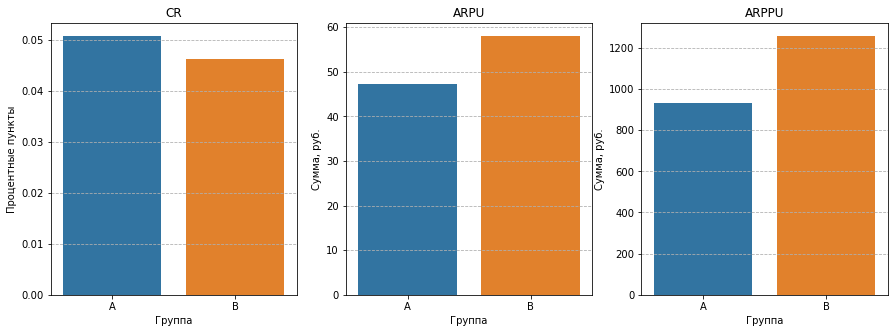

In [31]:
ab_test_vizualization(ab_test_result)